# Dynamic-Weighted-Tabular-Method - Image classification of Tabular Data using TF

## Made by Abhimanyu Singh (https://www.linkedin.com/in/abhimanyus1997)

The Dynamic Weighted Tabular Method (DWTM) is an innovative approach that leverages Convolutional Neural Networks (CNNs) for tabular data classification. It employs statistical techniques to assess the significance of features relative to the target class. This significance is then translated into pixel positions within an image representation of the data.

Key Concepts:

* Feature Importance: DWTM evaluates the contribution of each feature to the classification task. Features deemed more critical are granted more prominent positions in the image.
* Image Representation: Features are mapped to an image where their importance dictates their pixel locations. This facilitates the application of CNNs, which are typically designed for image data.

__Citation : Iqbal, Md Ifraham, et al. "A Dynamic Weighted Tabular Method for Convolutional Neural Networks." arXiv preprint arXiv:2205.10386 (2022)__

In [69]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

import scipy
from scipy.stats.stats import pearsonr
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from numpy import nan
from numpy import isnan
import statsmodels.api as sm

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from numpy import nan
from numpy import isnan
import statsmodels.api as sm

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score


from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder

import os

# Redirect stdout and stderr to /dev/null
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

/tmp/ipykernel_6121/624753428.py:9: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


# 1) Iris Dataset

In [2]:
!pip install split-folders
# from google.colab import drive
# drive.mount('/drive')

#### Downloading Dataset

In [3]:
import os
import urllib.request
import zipfile

# Define the URL of the dataset file
dataset_url = "https://drive.google.com/uc?id=1a_fWFbUDaQ9kmYxciAFlKmVO5CwG71SZ"

# Define the local file path for saving the dataset
zip_file_path = "IrisImageDataset.zip"
extracted_folder_path = "content"

# Download the dataset file
urllib.request.urlretrieve(dataset_url, zip_file_path)

# Unzip the dataset file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# List the contents of the extracted folder
extracted_files = os.listdir(extracted_folder_path)
print("Extracted files:", extracted_files)


Extracted files: ['content']


In [4]:
%ls

DWTM_Image_Classification_Tensorflow.ipynb*  IrisImageDataset.zip*  content/


In [5]:
import splitfolders  # or import split_folders
splitfolders.ratio("content/content/IrisImageDataset", output="content/content/IrisSplit", seed=1337, ratio=(.90,  .10), group_prefix=None) # default values

Copying files: 150 files [00:05, 29.57 files/s]


In [6]:
# import os
# os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [7]:
from __future__ import print_function, division

# Using TF & Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np
plt.ion()   # interactive mode

In [8]:
os.listdir("content/content/IrisSplit")

['train', 'val']

## DataLoaders

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ),
    'val': ImageDataGenerator(rescale=1./255)
}

data_dir = 'content/content/IrisSplit'
batch_size = 16
image_size = (128, 128)

train_generator = data_transforms['train'].flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = data_transforms['val'].flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Get dataset sizes
dataset_sizes = {
    'train': train_generator.samples,
    'val': val_generator.samples
}
print(f"Training samples: {dataset_sizes['train']}")
print(f"Validation samples: {dataset_sizes['val']}")

# Get Class Names
class_names = list(train_generator.class_indices.keys())


# TF GPU acess check
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set GPU device
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        device_name = '/GPU:0'
    except RuntimeError as e:
        print(e)
else:
    device_name = '/CPU:0'

print(f"Using device: {device_name}")

Found 135 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Training samples: 135
Validation samples: 15
Using device: /GPU:0


In [10]:
dataset_sizes, class_names, device_name

({'train': 135, 'val': 15}, ['0', '1', '2'], '/GPU:0')

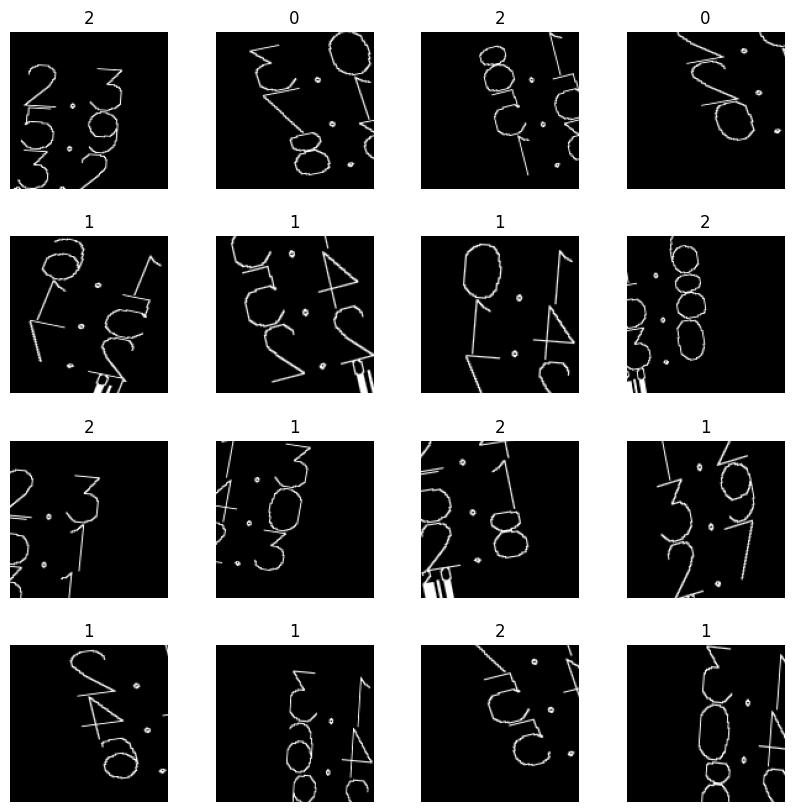

In [16]:
def imshow(inp, title=None, cmap='gray'):
    """Imshow for Tensor or NumPy array."""
    if isinstance(inp, tf.Tensor):
        inp = inp.numpy()  # Convert TensorFlow tensor to NumPy array
    inp = inp.astype(np.float32)
    # Convert to grayscale
    inp = np.mean(inp, axis=-1)
    plt.imshow(inp, cmap=cmap)
    plt.axis('off')
    if title is not None:
        plt.title(title)

# Assuming you have a TensorFlow generator `train_generator`
batch = next(train_generator)  # Get a batch of training data
inputs, labels = batch  # Unpack the batch into inputs and labels

# Plot the images in the batch in a grid
plt.figure(figsize=(10, 10))
for i in range(len(inputs)):
    plt.subplot(4, 4, i + 1)
    imshow(inputs[i], title=class_names[np.argmax(labels[i])], cmap='gray')  # Display each image with its label in grayscale
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

In [17]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_openml

In [19]:
# Data directories
data_dir = 'content/content/IrisSplit'
batch_size = 16
img_height = 128
img_width = 128

# Data augmentation and normalization for training and validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'val'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Normalize the pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


num_classes = len(class_names)

Found 135 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


In [20]:
def train_simple_network_with_input_reshape(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                                            epochs=25, device="cpu", checkpoint_file=None):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the TensorFlow model to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- TensorFlow Data Loader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional TensorFlow Data Loader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evaluate the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute location to perform training
    
    Here, we use the provided method but adapt it to TensorFlow, flattening the inputs before passing to the linear model.
    """
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score)
        if val_loader is not None:
            to_track.append("val " + eval_score)
        
    total_train_time = 0  # How long have we spent in the training loop? 
    results = {}
    # Initialize every item with an empty list
    for item in to_track:
        results[item] = []
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model.train()  # Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
      
            batch_size = tf.shape(inputs)[0]

            # Flatten the input to fit in linear model
            inputs = tf.reshape(inputs, [batch_size, -1])

            with tf.GradientTape() as tape:
                y_hat = model(inputs)

                # Compute loss
                loss = loss_func(y_hat, labels)
            
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Now we are just grabbing some information we would like to have
            running_loss += loss.numpy() * batch_size
            
            y_pred_batch = tf.argmax(y_hat, axis=1).numpy()
            y_true.extend(labels.numpy())
            y_pred.extend(y_pred_batch)

        end = time.time()
        total_train_time += (end - start)
        
        results["epoch"].append(epoch)
        results["total time"].append(total_train_time)
        results["train loss"].append(running_loss)
        
        if score_funcs is not None:
            for name, score_func in score_funcs.items():
                results["train " + name].append(score_func(y_true, y_pred))
      
        if val_loader is None:
            pass
        else:  # Let's find out validation performance as we go!
            model.evaluate(val_loader)  # Assuming evaluate method exists for the model
            
            y_true_val = []
            y_pred_val = []
            val_loss = 0.0

            for inputs_val, labels_val in val_loader:
        
                batch_size_val = tf.shape(inputs_val)[0]

                # Flatten the input to fit in linear model
                inputs_val = tf.reshape(inputs_val, [batch_size_val, -1])

                y_hat_val = model(inputs_val)

                # Compute loss
                val_loss += loss_func(y_hat_val, labels_val).numpy() * batch_size_val

                y_pred_batch_val = tf.argmax(y_hat_val, axis=1).numpy()
                y_true_val.extend(labels_val.numpy())
                y_pred_val.extend(y_pred_batch_val)
                        
            results["val loss"].append(val_loss)

            if score_funcs is not None:
                for name, score_func in score_funcs.items():
                    results["val " + name].append(score_func(y_true_val, y_pred_val))
                
        if checkpoint_file is not None:
            # Save the model and optimizer state
            model.save_weights(checkpoint_file)
            # Optionally, save additional training information
            # Save other information (e.g., epoch number, results, etc.) as needed
            # This depends on how you intend to resume training or analyze the results later

    return pd.DataFrame.from_dict(results)

In [21]:
def train_model(model, loss_fn, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    since = time.time()

    best_model_weights = copy.deepcopy(model.get_weights())
    best_acc = 0.0

    res_dict = {}
    epoch_loss_list = []
    epoch_acc_list = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                training = True
                loader = train_loader
            else:
                training = False
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in loader:
                if training:
                    with tf.GradientTape() as tape:
                        outputs = model(inputs, training=True)
                        preds = tf.argmax(outputs, axis=1)
                        loss = loss_fn(labels, outputs)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                else:
                    outputs = model(inputs, training=False)
                    preds = tf.argmax(outputs, axis=1)
                    loss = loss_fn(labels, outputs)

                # statistics
                running_loss += loss.numpy() * inputs.shape[0]
                running_corrects += np.sum(preds.numpy() == labels.numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects / len(loader.dataset)

            epoch_loss_list.append(epoch_loss)
            epoch_acc_list.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            res_dict[phase] = epoch_acc_list

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.get_weights())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.set_weights(best_model_weights)
    return model, epoch_loss_list, epoch_acc_list, res_dict

In [22]:
def visualize_model(model, val_loader, class_names, num_images=6):
    images_so_far = 0
    plt.figure(figsize=(10, 10))

    for inputs, labels in val_loader:
        inputs = inputs[:num_images]
        labels = labels[:num_images]
        
        predictions = model(inputs, training=False)
        predicted_labels = tf.argmax(predictions, axis=1)

        for j in range(inputs.shape[0]):
            images_so_far += 1
            plt.subplot(num_images//2, 2, images_so_far)
            plt.imshow(inputs[j].numpy().astype("uint8"))
            plt.title('predicted: {}'.format(class_names[predicted_labels[j].numpy()]))
            plt.axis('off')

            if images_so_far == num_images:
                plt.show()
                return

## Training, Testing and Evaluation

### Resnet-18

In [34]:
import logging
from tensorflow.keras import layers, optimizers, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping

# Suppress TensorFlow info and warning messages
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Define ResNet-18 model
def ResNet18(num_classes):
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(128, 128, 3),  # Adjust input shape to match your image size
        pooling='avg'  # Global average pooling
    )
    for layer in base_model.layers:
        layer.trainable = False  # Freeze layers of the base model
    
    x = layers.Dense(num_classes, activation='softmax')(base_model.output)
    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    return model

# Define training parameters
num_epochs = 50
learning_rate = 0.0005
batch_size = 32

# Create ResNet-18 model
model_ft = ResNet18(len(class_names))

# Compile the model
optimizer = optimizers.Adam(learning_rate)
loss_fn = losses.SparseCategoricalCrossentropy()
metrics_list = [metrics.SparseCategoricalAccuracy()]
model_ft.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics_list)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [35]:
# Train the model with early stopping
history = model_ft.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/50
9/9 [==============================] - 4s 180ms/step - loss: 1.1370 - sparse_categorical_accuracy: 0.4296 - val_loss: 1.0911 - val_sparse_categorical_accuracy: 0.5333
Epoch 2/50
9/9 [==============================] - 0s 47ms/step - loss: 1.0556 - sparse_categorical_accuracy: 0.5333 - val_loss: 1.0453 - val_sparse_categorical_accuracy: 0.5333
Epoch 3/50
9/9 [==============================] - 0s 45ms/step - loss: 1.0220 - sparse_categorical_accuracy: 0.6815 - val_loss: 1.0200 - val_sparse_categorical_accuracy: 0.6667
Epoch 4/50
9/9 [==============================] - 0s 45ms/step - loss: 0.9902 - sparse_categorical_accuracy: 0.8074 - val_loss: 0.9963 - val_sparse_categorical_accuracy: 0.7333
Epoch 5/50
9/9 [==============================] - 0s 45ms/step - loss: 0.9651 - sparse_categorical_accuracy: 0.8148 - val_loss: 0.9742 - val_sparse_categorical_accuracy: 0.7333
Epoch 6/50
9/9 [==============================] - 0s 45ms/step - loss: 0.9354 - sparse_categorical_accuracy: 0.881

In [47]:
# Get the test accuracy
test_loss, test_accuracy = model_ft.evaluate(val_ds)

1/1 [==============================] - 1s 932ms/step - loss: 0.5240 - sparse_categorical_accuracy: 0.8667


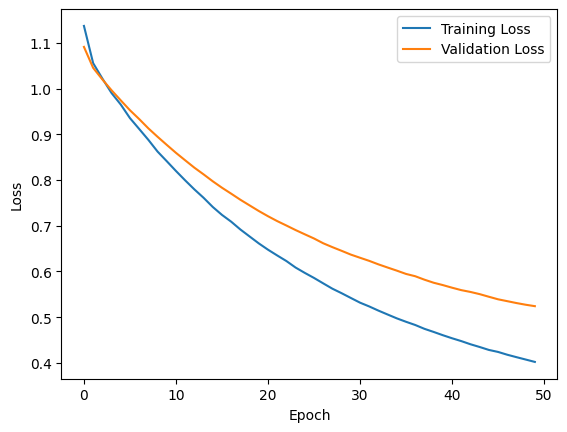

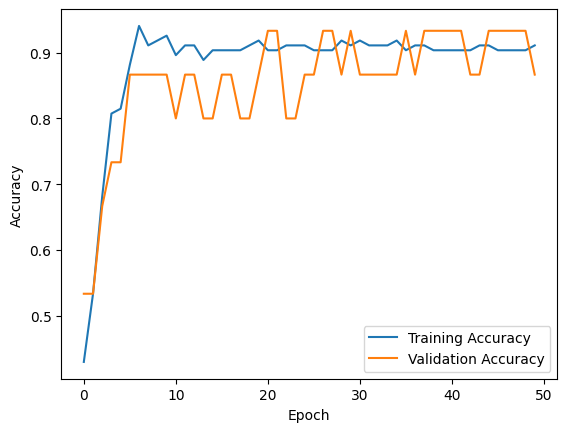

Test Loss: 0.5239936709403992
Test Accuracy: 0.8666666746139526


In [48]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

In [36]:
from tensorflow.keras.models import save_model, load_model

# Save the model
save_model(model_ft, "Iris_Resnet18")

# Load the model
model_ft = load_model("Iris_Resnet18")

1/1 [==============================] - 0s 31ms/step
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0


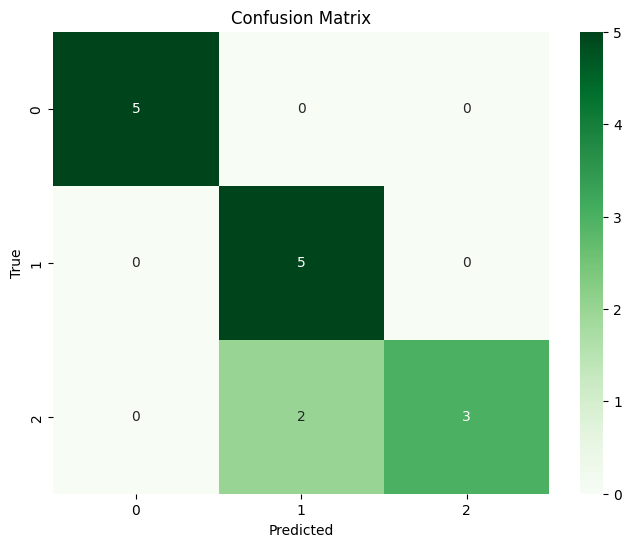

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

for inputs, labels in val_ds:
    predictions = model_ft.predict(inputs)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

# Calculate Sensitivity, Specificity, Precision, and Recall
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('Precision:', precision)
print('Recall:', recall)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 32ms/step
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0


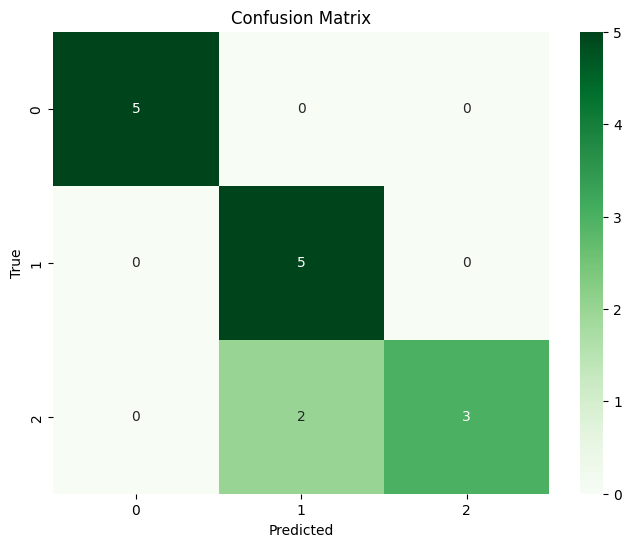

In [63]:
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix

def getConfusionMatrix(model, val_ds, class_names, show_image=False):
    cm = np.zeros((2, 2), dtype=int)  # Initialize a confusion matrix
    true_labels = []
    predicted_labels = []

    for inputs, labels in val_ds:
        predictions = model.predict(inputs)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(np.argmax(predictions, axis=1))

    # Compute the confusion matrix
    cm = sklearn_confusion_matrix(true_labels, predicted_labels)

    # Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
    TP = cm[1, 1]  # True Positives
    TN = cm[0, 0]  # True Negatives
    FP = cm[0, 1]  # False Positives
    FN = cm[1, 0]  # False Negatives

    # Calculate Sensitivity, Specificity, Precision, and Recall
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    print('Sensitivity:', sensitivity)
    print('Specificity:', specificity)
    print('Precision:', precision)
    print('Recall:', recall)

    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return cm

# Usage example:
confusion_matrix = getConfusionMatrix(model_ft, val_ds, class_names, show_image=False)

### Densenet121

Epoch 1/50
9/9 [==============================] - 6s 264ms/step - loss: 1.1443 - sparse_categorical_accuracy: 0.4222 - val_loss: 0.9506 - val_sparse_categorical_accuracy: 0.7333
Epoch 2/50
9/9 [==============================] - 1s 59ms/step - loss: 0.9073 - sparse_categorical_accuracy: 0.6444 - val_loss: 0.9199 - val_sparse_categorical_accuracy: 0.7333
Epoch 3/50
9/9 [==============================] - 1s 55ms/step - loss: 0.8497 - sparse_categorical_accuracy: 0.6815 - val_loss: 0.8516 - val_sparse_categorical_accuracy: 0.8000
Epoch 4/50
9/9 [==============================] - 1s 59ms/step - loss: 0.7734 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.8017 - val_sparse_categorical_accuracy: 0.8000
Epoch 5/50
9/9 [==============================] - 1s 60ms/step - loss: 0.7201 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.7733 - val_sparse_categorical_accuracy: 0.8000
Epoch 6/50
9/9 [==============================] - 1s 56ms/step - loss: 0.6652 - sparse_categorical_accuracy: 0.807

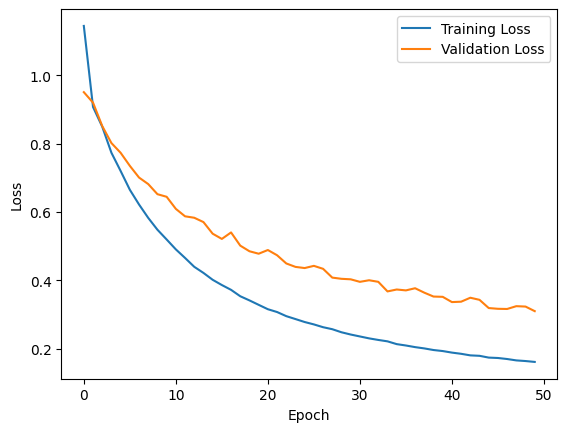

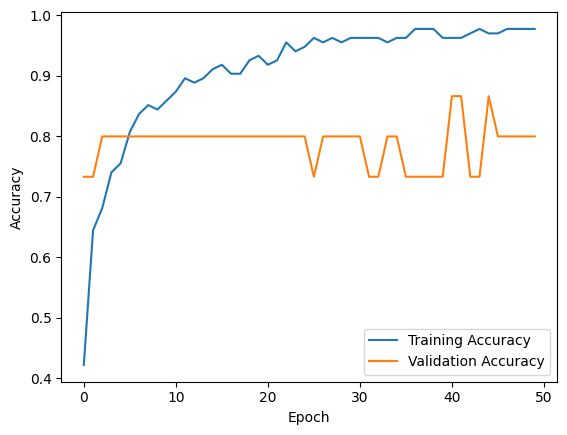

Test Loss: 0.5239936709403992
Test Accuracy: 0.8666666746139526
1/1 [==============================] - 2s 2s/step
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0


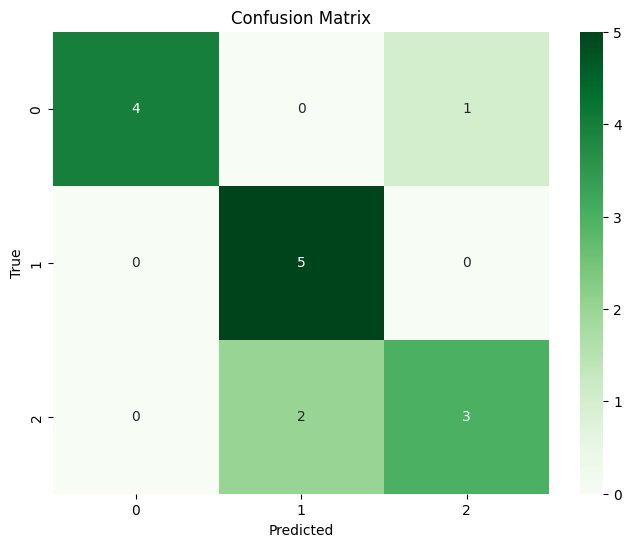

In [65]:
# Define ResNet-18 model
def DenseNet121(num_classes):
    base_model = tf.keras.applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(128, 128, 3),  # Adjust input shape to match your image size
        pooling='avg'  # Global average pooling,

    )
    for layer in base_model.layers:
        layer.trainable = False  # Freeze layers of the base model
    
    x = layers.Dense(num_classes, activation='softmax')(base_model.output)
    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    return model

# Define training parameters
num_epochs = 50
learning_rate = 0.0005
batch_size = 32

# Create ResNet-18 model
model_ft = DenseNet121(len(class_names))

# Compile the model
optimizer = optimizers.Adam(learning_rate)
loss_fn = losses.SparseCategoricalCrossentropy()
metrics_list = [metrics.SparseCategoricalAccuracy()]
model_ft.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics_list)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model_ft.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]
)




# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot confusion matrix
confusion_matrix = getConfusionMatrix(model_ft, val_ds, class_names, show_image=False)

# Save and load model
save_model(model_ft, "Iris_densenet121")
model_ft = load_model("Iris_densenet121")

### Inception V3

https://www.tensorflow.org/api_docs/python/tf/keras/applications

87910968/87910968 [==============================] - 7s 0us/step
Epoch 1/50
9/9 [==============================] - 19s 1s/step - loss: 1.1379 - sparse_categorical_accuracy: 0.5111 - val_loss: 1.0688 - val_sparse_categorical_accuracy: 0.4000
Epoch 2/50
9/9 [==============================] - 1s 53ms/step - loss: 0.7407 - sparse_categorical_accuracy: 0.6889 - val_loss: 0.9567 - val_sparse_categorical_accuracy: 0.4667
Epoch 3/50
9/9 [==============================] - 0s 48ms/step - loss: 0.5548 - sparse_categorical_accuracy: 0.7778 - val_loss: 0.8213 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/50
9/9 [==============================] - 0s 46ms/step - loss: 0.4362 - sparse_categorical_accuracy: 0.8593 - val_loss: 0.7774 - val_sparse_categorical_accuracy: 0.6000
Epoch 5/50
9/9 [==============================] - 0s 43ms/step - loss: 0.3865 - sparse_categorical_accuracy: 0.8741 - val_loss: 0.7085 - val_sparse_categorical_accuracy: 0.6667
Epoch 6/50
9/9 [==============================] - 0

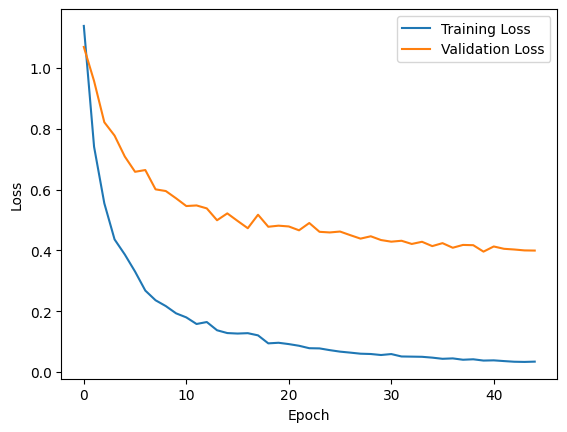

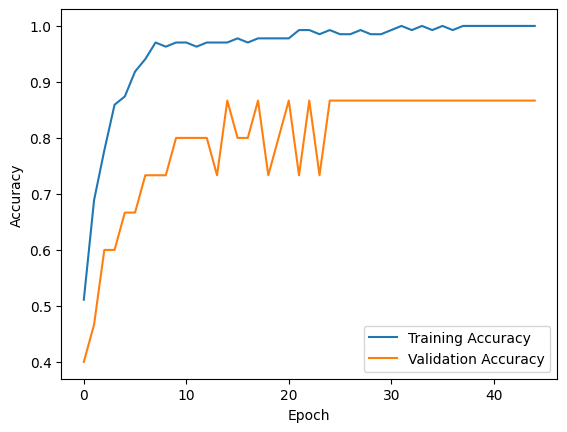

Test Loss: 0.5239936709403992
Test Accuracy: 0.8666666746139526
1/1 [==============================] - 1s 1s/step
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
Recall: 1.0


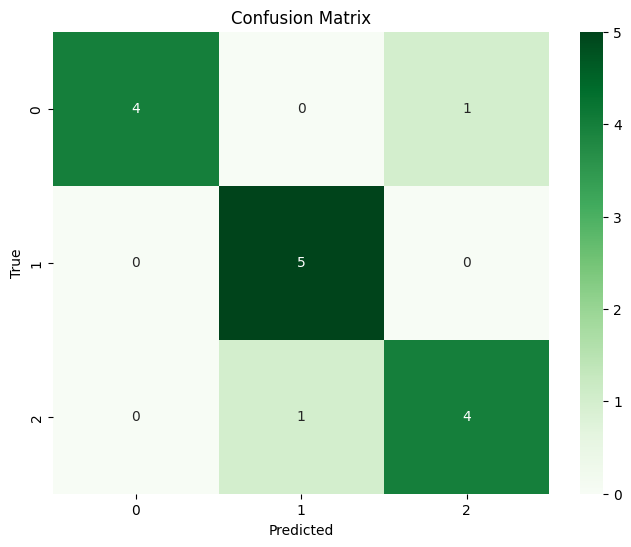

In [67]:
def InceptionV3(num_classes):
    base_model = tf.keras.applications.InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(128, 128, 3),  # Adjust input shape to match your image size
        pooling='avg'  # Global average pooling,

    )
    for layer in base_model.layers:
        layer.trainable = False  # Freeze layers of the base model
    
    x = layers.Dense(num_classes, activation='softmax')(base_model.output)
    model = tf.keras.Model(inputs=base_model.input, outputs=x)
    return model

# Define training parameters
num_epochs = 50
learning_rate = 0.0005
batch_size = 32

# Create ResNet-18 model
model_ft = InceptionV3(len(class_names))

# Compile the model
optimizer = optimizers.Adam(learning_rate)
loss_fn = losses.SparseCategoricalCrossentropy()
metrics_list = [metrics.SparseCategoricalAccuracy()]
model_ft.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics_list)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model_ft.fit(
    train_ds,
    epochs=num_epochs,
    validation_data=val_ds,
    callbacks=[early_stopping]
)



# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Plot confusion matrix
confusion_matrix = getConfusionMatrix(model_ft, val_ds, class_names, show_image=False)

# Save and load model
save_model(model_ft, "Iris_inceptionv3")
model_ft = load_model("Iris_inceptionv3")